In [8]:
import torch
device = torch.device("mps") if torch.backends.mps.is_available() else  torch.device("cpu")
print('Device:', device)
import os
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

Device: mps
Number of workers: 8


In [1]:
import pandas as pd

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv( './data/auto-mpg.data', names=column_names,  na_values='?', comment='\t', sep=' ',skipinitialspace=True )
print(df.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [19]:
df = df.dropna()
df = df.reset_index(drop=True)
print(df.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [20]:
df.head(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,1
9,15.0,8,390.0,190.0,3850.0,8.5,70,1


In [24]:
df['Cylinders'].unique()

array([8, 4, 6, 3, 5])

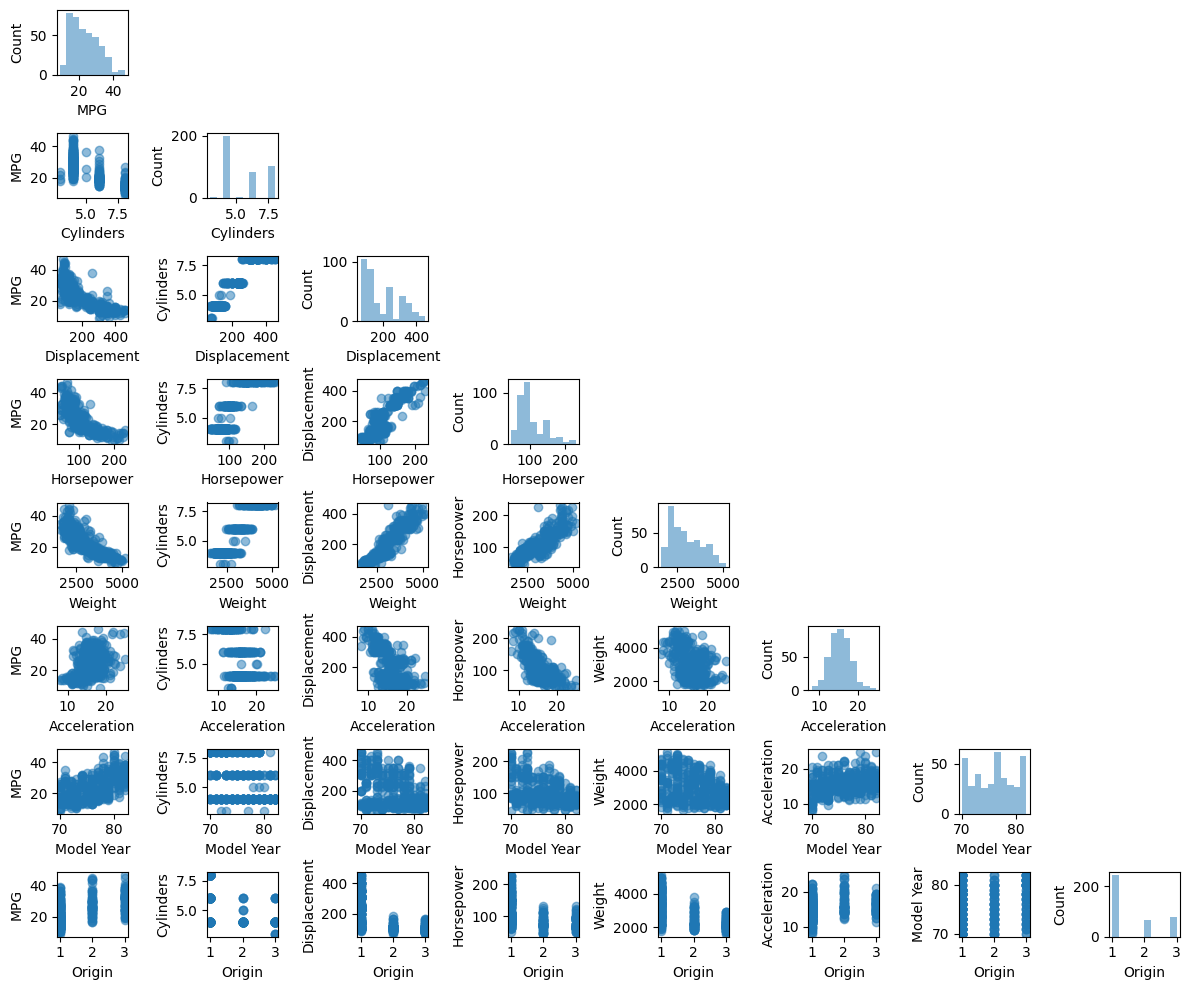

In [21]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

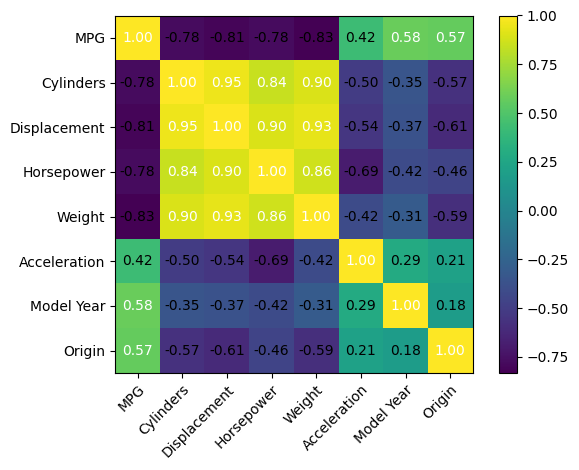

In [29]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier


mpg_boundaries = [0, 19, 29, 39, 49]
labels = [0,1,2,3]

x_selection = df.drop(columns ='MPG')
y_selection= pd.cut(df['MPG'], mpg_boundaries,  labels=labels, right=False)

forest = RandomForestClassifier(
    n_estimators=500,
    random_state=1
)

forest.fit(x_selection, y_selection)

importances = forest.feature_importances_
indexs = np.argsort(importances)[::-1]

for i in range(x_selection.shape[1]):
    print('%2d) %-*s %f' % (
        i+1, 
        30, 
        x_selection.columns[indexs[i]], 
        importances[indexs[i]]) 
    )

 1) Weight                         0.255326
 2) Displacement                   0.220985
 3) Horsepower                     0.209696
 4) Model Year                     0.125473
 5) Acceleration                   0.092939
 6) Cylinders                      0.060998
 7) Origin                         0.034584


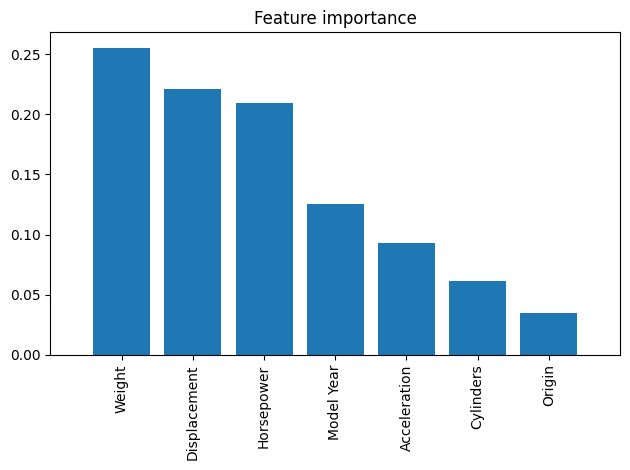

In [22]:
import matplotlib.pyplot as plt

plt.title('Feature importance')

plt.bar(
    range(x_selection.shape[1]),
    importances[indexs],
    align='center'
)

plt.xticks(
    range(x_selection.shape[1]),
    x_selection.columns[indexs], 
    rotation=90
)

plt.xlim([-1, x_selection.shape[1]])
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split( df, test_size=0.2,  random_state=0)
print(f'train:{len(df_train)}, test:{len(df_test)}')

train:313, test:79


In [ ]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [6]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

class AutoMPGDataset(Dataset):
    def __init__(self, df_data):
        self.data = df_data
        self.x, self.y = self.makeData()

    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
        

    def makeData(self):
        numeric_column_names = [ 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']
        sc = StandardScaler()
        std_data = sc.fit_transform(self.data[numeric_column_names])
        df_data_std = pd.DataFrame(data=std_data, columns=numeric_column_names)

        boundaries = [0, 73, 76, 79, 83]
        labels = [0,1,2,3]
        df_data_std['Model Year Bucketed'] = pd.cut(self.data['Model Year'], boundaries,  labels=labels, right=False)
                
        origin_encoded = pd.get_dummies(self.data['Origin'], dtype=int)
        df_data_std = pd.concat([df_data_std, origin_encoded], axis=1)

        df_data_std['MPG'] = self.data['MPG']
        
        x = torch.tensor(df_data_std.drop(columns='MPG').values).to(torch.float32)
        y = torch.tensor(df_data_std['MPG']).to(torch.float32)
        
        return x, y

In [7]:
import torch.utils.data as data

train_data = AutoMPGDataset(df_train)
test_set = AutoMPGDataset(df_test)

# use 20% of training data for validation
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size

seed = torch.Generator().manual_seed(7777)

train_set, valid_set = data.random_split(
    train_data,
    [train_set_size,valid_set_size],
    generator=seed
)

print(f'train_set_size:{train_set_size}, valid_set_size:{valid_set_size}, test_set_size:{len(test_set)}')

train_set_size:250, valid_set_size:63, test_set_size:79


In [ ]:
for batch in train_set:
    print(f'batch_x:{batch[0]}, batch_y:{batch[1]}')
    

In [8]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)


print(f'train_loader : batch_size:{batch_size}, batch_count:{len(train_loader)}')
print(f'valid_loader : batch_size:{batch_size}, batch_count:{len(valid_loader)}')
print(f'test_loader : batch_size:{batch_size}, batch_count:{len(test_loader)}')

train_loader : batch_size:8, batch_count:31
valid_loader : batch_size:8, batch_count:7
test_loader : batch_size:8, batch_count:9


In [ ]:
for x_batch, y_batch in valid_loader:
    print(f'batch_x:{x_batch}, batch_y:{y_batch}')

In [9]:
from torch import nn

class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__() 
           
        self.l1 = nn.Sequential(
            nn.Linear(9, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )

    
    def forward(self, x):
        out = self.l1(x)
        return out

In [10]:
import lightning as L


class AutoMPGPred(L.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr 
        self.loss_fn = nn.MSELoss()
        self.loss_hist_train = 0
        self.loss_hist_valid = 0
        self.loss_hist_test = 0
    
    def training_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        pred = self.model(x_batch)
        loss = self.loss_fn( pred, y_batch)
        self.loss_hist_train += loss
        values = {"loss": loss}  
        self.log_dict(values)
        
        return {"loss":loss}

    
    def on_train_epoch_end(self):
        loss = self.loss_hist_train / ( len(train_loader) * batch_size)
        self.log('total_training_loss', loss, prog_bar=True)
        self.loss_hist_train = 0
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        pred = self.model(x_batch)
        loss = self.loss_fn( pred, y_batch)
        self.loss_hist_valid += loss
        values = {"loss": loss}  
        self.log_dict(values)
        
        return {"loss":loss}

        
    def on_validation_epoch_end(self):
        loss = self.loss_hist_train / ( len(valid_loader) * batch_size)
        self.log('total_valid_loss', loss, prog_bar=True)
        self.loss_hist_valid = 0
        return loss
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        self.model.eval()
        with torch.no_grad():
            x_batch, y_batch = batch
            pred = self.model(x_batch)
        return pred



In [14]:
model = AutoMPGPred(Linear()).to(device)

log_path = os.getcwd()

In [20]:
trainer = L.Trainer(
    fast_dev_run=True,
    accelerator='mps',
    devices=1
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [15]:
trainer = L.Trainer(
    default_root_dir=log_path,
    precision="bf16-mixed",
    accelerator='mps',
    devices=1,
    max_epochs=1000,
    num_sanity_val_steps=2,
    check_val_every_n_epoch=100
)


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(
    model,
    train_loader, 
    valid_loader
)


  | Name    | Type    | Params
------------------------------------
0 | model   | Linear  | 121   
1 | loss_fn | MSELoss | 0     
------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [ ]:
trainer = L.Trainer(accelerator='mps', devices=1)
pred = trainer.predict(model, test_loader)

In [ ]:
with torch.no_grad():
    pred = model(valid_set[:][0].to(device))[:, 0]
    loss = loss_fn(pred, valid_set[:][1].to(device))
    print(f'테스트 MSE: {loss.item():.4f}')
    print(f'테스트 MAE: {nn.L1Loss()(pred, valid_set[:][1].to(device)).item():.4f}')

In [ ]:
test_data = valid_set[0]

with torch.no_grad():
    pred = model(test_data[0].reshape(1,9).to(device))
    result = (test_data[1].item() - pred.reshape(1).item()) * -1
    print(f'target: {test_data[1].item():.4f}, predict: {pred.reshape(1).item():.4f}, result: {result:.4f} ')